# 3. Wavelet Coefficient Maps Generation Notebook

### This notebook is designed to generate wavelet coefficient maps for each frequency total maps. 


### 3.1 We first create the directory structure to store the outputs.

In [1]:
# !pip install s2fft --upgrade
# !pip install conan
# !pip isntall pyssht
# !pip install healpy --upgrade
# !pip install matplotlib --upgrade
# !pip install numpy --upgrade
# !pip install jax --upgrade

In [3]:
import os

def check_and_create_directories(chosen_map="CSN"):
    root_dir = f"data/wavelet_transform/{chosen_map}"
    os.makedirs(root_dir, exist_ok=True)
    print(f"Ensured directory exists: {root_dir}")

    # now create the sub-tree under root_dir
    sub_dirs = ["maps", "wavelets"]
    wavelet_sub_dirs = ["wav_MW_maps", "scal_coeffs"]

    for sub in sub_dirs:
        path = os.path.join(root_dir, sub)
        os.makedirs(path, exist_ok=True)
        print(f"Ensured directory exists: {path}")

        if sub == "wavelets":
            for wsub in wavelet_sub_dirs:
                nested = os.path.join(path, wsub)
                os.makedirs(nested, exist_ok=True)
                print(f"Ensured directory exists: {nested}")


# Run the function to check and create directories as needed
check_and_create_directories("CSN")
check_and_create_directories("CMB")


Ensured directory exists: data/wavelet_transform/CSN
Ensured directory exists: data/wavelet_transform/CSN/maps
Ensured directory exists: data/wavelet_transform/CSN/wavelets
Ensured directory exists: data/wavelet_transform/CSN/wavelets/wav_MW_maps
Ensured directory exists: data/wavelet_transform/CSN/wavelets/scal_coeffs
Ensured directory exists: data/wavelet_transform/CMB
Ensured directory exists: data/wavelet_transform/CMB/maps
Ensured directory exists: data/wavelet_transform/CMB/wavelets
Ensured directory exists: data/wavelet_transform/CMB/wavelets/wav_MW_maps
Ensured directory exists: data/wavelet_transform/CMB/wavelets/scal_coeffs


### 3.2 Functions used to generate wavelet coefficient maps.

wavelet_transform: Applies the wavelet transform to the input map using specified parameters (L_max, N_directions).
save_wavelet_scaling_coeffs: Saves the computed wavelet and scaling coefficients to .npy files.
load_wavelet_scaling_coeffs: Loads previously saved wavelet and scaling coefficients from files.
generate_wavelet_coeffs: The main function that reads a CMB map, converts it to spherical harmonic coefficients, applies the wavelet transform, saves the results, and visualizes the wavelet coefficient maps.

In [8]:
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
import s2fft
import healpy as hp
import numpy as np
import s2wav
import s2wav.filters as filters
import matplotlib.pyplot as plt
import os
import skyclean as sc




def hp_alm_2_mw_alm(hp_alm, L_max):
    """
    Converts spherical harmonics (alm) to a matrix representation for use in MW sampling.

    This function takes 1D Healpix spherical harmonics coefficients (alm) and converts them into a matrix form 
    that is in (MW sampling, McEwen & Wiaux) sampling. The matrix form is complex-valued 
    and indexed by multipole moment and azimuthal index.

    Parameters:
        hp_alm (numpy.ndarray): The input healpix spherical harmonics coefficients (alm).
        L_max (int): The maximum multipole moment to be represented in the output matrix.
    
    Note: # L_max = 4 | l = 0,1,2,3 , true lmax is L_max-1 = 3 | m = -3...0...(L_max-1 = 3)| number of m = 2(L_max-1)+1 = 2L_max-1

    Returns:
        MW_alm (numpy.ndarray): 2D array of shape (Lmax, 2*Lmax-1) MW spherical harmonics coefficients 
    """
    L = L_max + 1 
    MW_alm = np.zeros((L, 2 * L - 1), dtype=np.complex128)
    for l in range(L):
        for m in range(l + 1):
            index = hp.Alm.getidx(L_max, l, m)
            col = m + L - 1
            hp_point = hp_alm[index]
            MW_alm[l, col] = hp_point
            if m > 0: 
                MW_alm[l, L-m-1] = (-1)**m * hp_point.conj() # fill m < 0 by symmetry
    return MW_alm

def mw_alm_2_hp_alm(MW_alm):
    L = MW_alm.shape[0]
    L_max = L-1
    hp_alm = np.zeros(hp.Alm.getsize(L_max), np.complex128)
    for l in range(L):
        for m in range(l+1):
            col = L_max + m
            idx = hp.Alm.getidx(L_max, l, m)
            hp_alm[idx] = MW_alm[l, col]
    return hp_alm

def visualize_MW_Pix_map(MW_Pix_Map, title, coord=["G"], unit = r"K"):
    """
    Processes a MW pixel wavelet coefficient map and visualizes it using HEALPix mollview.

    Parameters:
        MW_Pix_Map (numpy array): Array representing the wavelet coefficient map.
        title (str): Title for the visualization plot.

    Returns:
        Only Displays a mollview map.
    """
    nrows = 1
    ncols = MW_Pix_Map.shape[0]
    fig = plt.figure(figsize=(5*ncols, 5*nrows))
    
    L_max = MW_Pix_Map.shape[1]
    for i in range(ncols):
        original_map_alm = s2fft.forward(MW_Pix_Map[i], L=L_max)
        #print("ME alm shape:", original_map_alm.shape)
        original_map_hp_alm = mw_alm_2_hp_alm(original_map_alm)
        original_hp_map = hp.alm2map(original_map_hp_alm, nside=L_max//2)
        panel = i + 1
        hp.mollview(
            original_hp_map,
            coord=coord,
            title=title+f", dir {i+1}",
            unit=unit,
            fig = fig.number,
            sub = (nrows, ncols, panel)
            # min=min, max=max,  # Uncomment and adjust these as necessary for better visualization contrast
        )
        # plt.figure(dpi=1200)
    plt.show()


def wavelet_transform(
    mw_pix_map: jnp.ndarray,
    L_max: int,
    N_directions: int,
    lam: float = 2.0,
):
    # default JAX path
    j_filter = filters.filters_directional_vectorised(L_max, N_directions, lam = lam)
    return s2wav.analysis(
        mw_pix_map,
        N       = N_directions,
        L       = L_max,
        lam     = lam,
        filters = j_filter,
        reality = False,
    )

def save_wavelet_scaling_coeffs(wavelet_coeffs, scaling_coeffs, frequency, realization, wav_template, scal_template):
    
    # Save wavelet coefficients
    for scale, wav in enumerate(wavelet_coeffs):
        np_wav = np.array(wav)  # Convert JAX array to numpy array
        np.save(wav_template.format(frequency=frequency, scale=scale, realization=realization), np_wav)
    
    # Scaling coefficient is the same for all scales'
    np_scaling = np.array(scaling_coeffs)  # Convert JAX array to numpy array
    np.save(scal_template.format(frequency=frequency, realization=realization), np_scaling)



def load_wavelet_scaling_coeffs(frequency, num_wavelets, realization, wav_template, scal_template):
    wavelet_coeffs = [np.real(np.load(wav_template.format(frequency=frequency, scale=scale, realization=realization))) for scale in range(num_wavelets)]
    scaling_coeffs = np.real(np.load(scal_template.format(frequency=frequency, realization=realization)))
    return wavelet_coeffs, scaling_coeffs

def generate_wavelet_coeffs(CMB_map_path, frequency, L_max, N_directions, realization, wav_template, scal_template, lam=2, visualize=True):
    L = L_max + 1 # L in MW sampling
    # Step 1: Read the Healpix map
    healpix_map = hp.read_map(CMB_map_path)

    # Step 2: map → alm
    hp_alm = hp.map2alm(healpix_map, L_max)
    # Step 3: alm → MW alm
    mw_alm = hp_alm_2_mw_alm(hp_alm, L_max)

    # Step 4: inverse MW → pixel map
    original_MW_Map = s2fft.inverse(mw_alm, L, method="jax")

    # Step 5: wavelet transform
    wavelet_coeffs, scaling_coeffs = wavelet_transform(
        original_MW_Map,
        L_max,
        N_directions,
        lam,
    )

    # Step 6: save coefficients
    save_wavelet_scaling_coeffs(
        wavelet_coeffs,
        scaling_coeffs,
        frequency,
        realization,
        wav_template,
        scal_template
    )
    loaded_wavelet_coeffs, loaded_scaling_coeffs = load_wavelet_scaling_coeffs(
        frequency,
        len(wavelet_coeffs),
        realization,
        wav_template,
        scal_template
    )

    if visualize:
        for scale, wav in enumerate(loaded_wavelet_coeffs):
            visualize_MW_Pix_map(wav, f"Scale {scale}")


    return loaded_wavelet_coeffs, loaded_scaling_coeffs, original_MW_Map



### 3.3 Generate wavelet coefficient maps for CMB maps in batch

In [9]:
def process_cmb_data(L_max, N_directions, realization_list, frequencies, data_path_template, lam=2, chosen_map = "CSN", visualize = True):
    """
    Process CMB data and generate wavelets for each frequency and realization.

    Parameters:
    L_max (int): The maximum multipole moment.
    N_directions (int): The number of directions for the wavelets.
    realization_list (list): A list of realizations to process.
    frequencies (list): A list of frequency strings.
    data_path_template (str): Template for the data path with a placeholder for frequency.
    generate_wavelets (function): Function to generate wavelets, taking parameters CMB_map_path, frequency, L_max, N_directions, realization.
    """
    
       
    for realization in realization_list:
        realization_str = str(realization).zfill(4)
        print(f"Processing realization {realization}")
        for frequency in frequencies:
            print(f"Generate Wavelet coefficient map for frequency {frequency}")
            map_path = data_path_template.format(frequency=frequency, L_max = L_max, realization=realization_str)
            if not os.path.exists(map_path): 
                print(f"File {map_path} does not exist")
                continue 
            wavelet_path = f"wavelet_transform/{chosen_map}/wavelets/wav_MW_maps/Wav_MW_Pix_F{frequency}_S5_R{realization_str}.npy"
            if os.path.exists(wavelet_path): 
                print(f"File {wavelet_path} already exist")
                continue 
            wav_template = f"data/wavelet_transform/{chosen_map}/wavelets/wav_MW_maps/Wav_MW_Pix_F{{frequency}}_S{{scale}}_R{{realization:04d}}.npy"
            scal_template =  f"data/wavelet_transform/{chosen_map}/wavelets/scal_coeffs/Scal_MW_Pix_F{{frequency}}_R{{realization:04d}}.npy"
            wavelet, scal, original = generate_wavelet_coeffs(map_path, frequency, L_max, N_directions, realization, wav_template, scal_template, lam, visualize = visualize)
            # return wavelet, scal, original
        # You can add any additional processing or saving logic here if needed


In [11]:
# Example usage
# This L_max should match the L_max of the total map (CSN)
L_max = 1024
lam = 4
N_directions = 1
realization_list = range(1)
frequencies = ["030", "100", "353"]
#frequencies = ["030", "044", "070", "100", "143", "217", "353", "545", "857"]
#CMB_data_path_template = 'data/CMB_total/CMB_HP_Map_F{frequency}_L{L_max}_R{realization}.fits'
CSN_data_path_template = 'data/CMB_total/CSN_HP_Map_F{frequency}_L{L_max}_R{realization}.fits'

#process_cmb_data(L_max, N_directions, realization_list, frequencies, CMB_data_path_template, lam = 2, chosen_map="CMB", visualize= False)
process_cmb_data(L_max, N_directions, realization_list, frequencies, CSN_data_path_template, lam=lam, chosen_map="CSN", visualize = False)

Processing realization 0
Generate Wavelet coefficient map for frequency 030
Generate Wavelet coefficient map for frequency 100
Generate Wavelet coefficient map for frequency 353


In [ ]:
# synthesise wavelet maps from wavelet coefficients
from s2wav import filters
L_max = 256
N_directions = 1
filter = filters.filters_directional_vectorised(L_max, N_directions, lam = lam)
# f_scal = np.array([[0]]) #np.load(f"wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_F030.npy") 
f_scal = np.load(f"data/wavelet_transform/CSN/wavelets/scal_coeffs/Scal_MW_Pix_F100_R0000.npy") 
wavelet_coeffs = [np.real(np.load(f"data/wavelet_transform/CSN/wavelets/wav_MW_maps/Wav_MW_Pix_F100_S{scale}_R0000.npy")) for scale in range(9)]

MW_Pix = s2wav.synthesis(wavelet_coeffs, L = L_max, f_scal = f_scal, filters = filter, lam = lam, N = N_directions)
print(MW_Pix.shape)
title = "Original CMB Signal Map"
visualize_MW_Pix_map(MW_Pix, title)

## ALM ISSUE TESTING

Shapes: 
 hp_map_og: (196608,) 
 hp_map_round_loop: (196608,) 
 mw_alm: (257, 513) 
 hp_alm: (33153,)


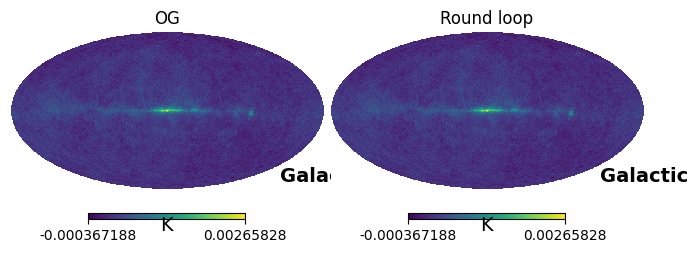

In [2]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt


## OLD 
def hp_alm_2_mw_alm(hp_alm, L_max):
    MW_alm = np.zeros((L_max, 2 * L_max - 1), dtype=np.complex128)
    for l in range(L_max):
        for m in range(-l, l + 1):
            index = hp.Alm.getidx(L_max - 1, l, abs(m))
            if m < 0:
                MW_alm[l, L_max + m - 1] = (-1) ** m * np.conj(hp_alm[index])
            else:
                MW_alm[l, L_max + m - 1] = hp_alm[index]

    return MW_alm

## NEw 
def hp_alm_2_mw_alm_new(hp_alm, L_max):
    L = L_max + 1 
    MW_alm = np.zeros((L, 2 * L - 1), dtype=np.complex128)
    for l in range(L):
        for m in range(l + 1):
            index = hp.Alm.getidx(L_max, l, m)
            col = m + L - 1
            hp_point = hp_alm[index]
            MW_alm[l, col] = hp_point
            if m > 0: 
                MW_alm[l, L-m-1] = (-1)**m * hp_point.conj() # fill m < 0 by symmetry
    return MW_alm

## OLD 
def mw_alm_2_hp_alm(MW_alm, lmax):
    hp_alm = np.zeros(hp.Alm.getsize(lmax), dtype=np.complex128)
    for l in range(lmax + 1):
        for m in range(-l, l + 1):
            index = hp.Alm.getidx(lmax, l, abs(m))
            if m < 0:
                hp_alm[index] = (-1)**m * np.conj(MW_alm[l, lmax + m])
            else:
                hp_alm[index] = MW_alm[l, lmax + m]

    return hp_alm

## NEW
def mw_alm_2_hp_alm_new(MW_alm):
    L = MW_alm.shape[0]
    L_max = L-1
    hp_alm = np.zeros(hp.Alm.getsize(L_max), np.complex128)
    for l in range(L):
        for m in range(l+1):
            col = L_max + m
            idx = hp.Alm.getidx(L_max, l, m)
            hp_alm[idx] = MW_alm[l, col]
    return hp_alm


frequencies = ["030"]
L_max = 256
CSN_data_path_template = 'data/CMB_total/CSN_HP_Map_F{frequency}_L{L_max}_R{realization}.fits'
hp_map_og = hp.read_map(CSN_data_path_template.format(frequency=frequencies[0], L_max = L_max, realization='0000'))
hp_alm = hp.map2alm(hp_map_og, L_max)

method = "new"
if method == "old": 
    mw_alm = hp_alm_2_mw_alm(hp_alm, L_max)
    hp_alm = mw_alm_2_hp_alm(mw_alm, L_max - 1) # change to just L_max to fix
elif method == "new":
    mw_alm = hp_alm_2_mw_alm_new(hp_alm, L_max)
    hp_alm = mw_alm_2_hp_alm_new(mw_alm)

hp_map_round_loop = hp.alm2map(hp_alm, nside=(L_max)//2)

fig = plt.figure()
hp.mollview(hp_map_og, coord=["G"], title="OG", unit=r"K", fig = fig.number, sub=(1, 2, 1))
hp.mollview(hp_map_round_loop, coord=["G"], title="Round loop", unit = r"K", fig = fig.number, sub=(1, 2, 2))
print(f"Shapes: \n hp_map_og: {hp_map_og.shape} \n hp_map_round_loop: {hp_map_round_loop.shape} \n mw_alm: {mw_alm.shape} \n hp_alm: {hp_alm.shape}")